# To visualize approaches

A simulated dataset is made to vizualize the filtering performed by the clustering approaches and the 

In [12]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))

sys.path.insert(1, module_path + '/src')
import utility

sys.path.insert(1, module_path + '/src/models')
import bootstrapped_ensemble_lr_filter as BE_LR_filter
import helper

from sklearn.datasets import make_blobs
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
import pprint


figure_path = module_path + '/figures/lr_filter/'

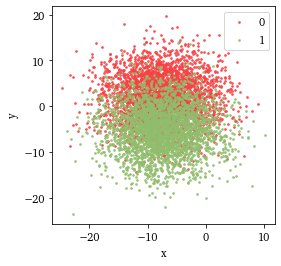

In [14]:
# generate 2d classification dataset
X, y = make_blobs(n_samples=6000, centers=2, n_features=2, cluster_std = 5, random_state = 43)
# scatter plot, dots colored by class value

X, y = pd.DataFrame(X), pd.Series(y)

y = y.astype(int)
X.columns = np.arange(len(X.columns))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train = X_train.reset_index(drop = True)
X_val = X_val.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

y_train = y_train.reset_index(drop = True)
y_val = y_val.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

f, ax = helper.scatterplot_with_colors(X.values, y.values)

f.savefig(figure_path + 'simulated_dataset.pdf', bbox_inches='tight')

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

k_range = list(range(1,8))
weight_options = ["uniform", "distance"]
grid = dict(n_neighbors = k_range, weights = weight_options)

clf = KNeighborsClassifier()

clf_dict = {
    'knnOptimal': clf,
    'nb': GaussianNB()
}

grid_dict = {
    'knnOptimal': grid
}

thresh_list = [2,4,6]
folds_list = [5, 7, 10]


param_dict = BE_LR_filter.hyperparam_search(X_train,y_train, X_val, y_val, clf_dict, grid_dict = grid_dict, thresh_list = thresh_list, folds_list = folds_list)

pprint.pprint(param_dict)

{'knnOptimal': {'folds': 10, 'threshold': 6},
 'nb': {'folds': 7, 'threshold': 4}}


In [4]:
_, indices = BE_LR_filter.bootstrapped_ensemble_lr_filter(X_train,y_train, X_test, y_test, clf_dict, param_dict = param_dict)

auc_init, auc_filtered, _ = helper.get_auc_scores(X_test, y_test, clf_dict, indices)
print('AUC score for the initial classifiers: ')
pprint.pprint(auc_init)
print('AUC score for the filtered dataset: ')
pprint.pprint(auc_filtered)

AUC score for the initial classifiers: 
{'knnOptimal': 0.7501750953296793, 'nb': 0.7577764560705272}
AUC score for the filtered dataset: 
{'knnOptimal': 0.7695021430926476, 'nb': 0.7719639125268061}


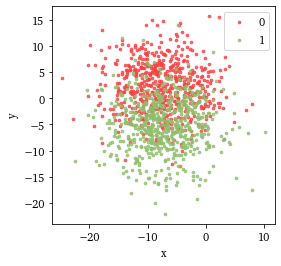

In [5]:
deleted=indices['knnOptimal']
mask=np.full(len(X_test),True,dtype=bool)
mask[deleted]=False

new_y_test = y_test.copy()
new_y_test.iloc[mask] = -1

f = helper.scatterplot_with_colors(X_test.values, y_test.values)

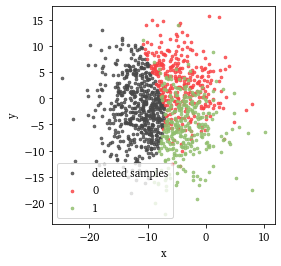

In [6]:
f = helper.scatterplot_with_colors(X_test.values, new_y_test.values)
f.savefig(figure_path + 'simulated_data_LR_filtered.pdf', bbox_inches='tight')

#f.savefig(figure_path + 'simulated_data_SVM_filtered.pdf', bbox_inches='tight')

# Adding noise

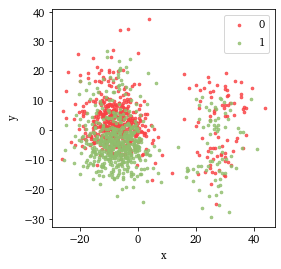

In [7]:
new_X, n_idx= helper.add_noise_dataset(X_test, 20, 3)
f = helper.scatterplot_with_colors(new_X.values, y_test.values)

f.savefig(figure_path + 'simulated_data_with_noise_lr_not_filtered.pdf', bbox_inches='tight')

{'knnOptimal': {'filtered': 0.6901595744680851, 'original': 0.69},
 'nb': {'filtered': 0.7033997655334114, 'original': 0.7041666666666667}}


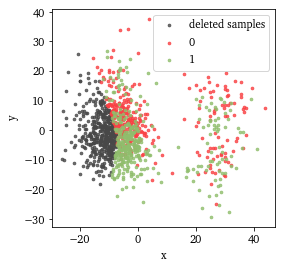

In [8]:
dict_results, indices = BE_LR_filter.bootstrapped_ensemble_lr_filter(X_train,y_train, new_X, y_test, clf_dict, param_dict = param_dict)

deleted=indices['knnOptimal']
mask=np.full(len(new_X),True,dtype=bool)
mask[deleted]=False

new_y_test = y_test.copy()
new_y_test.iloc[mask] = -1
f = helper.scatterplot_with_colors(new_X.values, new_y_test.values)

pprint.pprint(dict_results)

f.savefig(figure_path + 'simulated_data_with_noise_lr_filtered.pdf', bbox_inches='tight')
#f.savefig(figure_path + 'simulated_data_with_noise_SVM_filtered.pdf', bbox_inches='tight')

Clearly this algorithm is not targeting the instances where noise in the data is the problem

# Gradually adding more noise and seeing the effect

Firstly gradually increasing the amplitude 

In [9]:
ampl_list = [5, 10, 15, 20, 25, 30, 35, 40]
filtered = {}
init = {}
removed_data = {}

for ampl in ampl_list:
    new_X, n_idx= helper.add_noise_dataset(X_test, ampl, 4)
    
    dict_results, indices = BE_LR_filter.bootstrapped_ensemble_lr_filter(X_train,y_train, new_X, y_test, clf_dict, param_dict = param_dict)
    auc_init, auc_filtered, rm_data = helper.get_auc_scores(new_X, y_test, clf_dict, indices)
    
    filtered[ampl] = auc_filtered
    init[ampl] = auc_init
    removed_data[ampl] = rm_data

a_file = open(module_path + '/src/models/dictionaries_filter_results/simulated_lr_amplitude.pkl', 'wb')
pickle.dump(init,a_file)
pickle.dump(filtered, a_file)
pickle.dump(removed_data, a_file)
a_file.close()

In [10]:
amount_list = [12, 10, 7, 5, 4, 3, 2] # Is invertly large --> 3 means more noise is added than 4
filtered = {}
init = {}
removed_data = {}

for am in amount_list:
    new_X, n_idx= helper.add_noise_dataset(X_test, 15, am)
    
    dict_results, indices = BE_LR_filter.bootstrapped_ensemble_lr_filter(X_train,y_train, new_X, y_test, clf_dict, param_dict = param_dict)

    auc_init, auc_filtered, rm_data = helper.get_auc_scores(new_X, y_test, clf_dict, indices)
    
    filtered[am] = auc_filtered
    init[am] = auc_init
    removed_data[am] = rm_data


a_file = open(module_path + '/src/models/dictionaries_filter_results/simulated_lr_amount.pkl', 'wb')
pickle.dump(init,a_file)
pickle.dump(filtered, a_file)
pickle.dump(removed_data, a_file)
a_file.close()